# 概要
- 空港の来客数の予測をpystanを使って行う

# 必要なライブラリのインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy  
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.style.use("ggplot")
import seaborn as sns

#import missingno as msno

#from tqdm import tqdm_notebook as tqdm

#import plotly
#plotly.offline.init_notebook_mode(connected=False)

import warnings
warnings.filterwarnings('ignore') # warningが出ないように設定
pd.set_option("display.max_rows", None) # pandasの表示上限をなくす
pd.set_option("display.max_columns", None) # pandasの表示上限をなくす

import pystan

# データを調べる

## データのクレンジング
- datetime型に直す

In [7]:
df = pd.read_csv("../data/AirPassengers.csv")

In [8]:
df.head()

,TravelDate,Passengers
0,1/1/1949,112
1,2/1/1949,118
2,3/1/1949,132
3,4/1/1949,129
4,5/1/1949,121


In [9]:
type(df.TravelDate)

pandas.core.series.Series

In [10]:
df.TravelDate = pd.to_datetime(df.TravelDate)

In [11]:
df.head()

,TravelDate,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [17]:
len(df)

144

## データの可視化

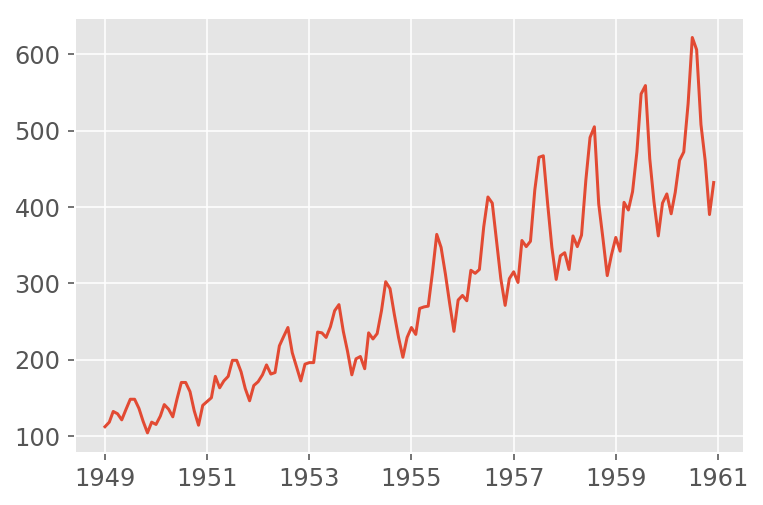

In [13]:
plt.plot(df.TravelDate, df.Passengers)

## 学習と予測データの分離

In [29]:
train_num = int(len(df)*0.8)
print(train_num)

115


In [31]:
df_train = df[:train_num]
df_test = df[train_num:]

# 統計的モデルの定義
- μ[n] = μ[n-1] + ε[n]
- ε[n] = Normal(0, σ)
- y[n] = Normal(μ[n] , σ)
と仮定する

## モデルの定義

In [14]:
stan_model ="""  
data {
    int  T;
    int T_new;
    real Y[T];
}

parameters {
    real mu[T];
    real<lower=0> s_mu;
    real<lower=0> s_Y;
}
model {
    for (t in 2:T){
        mu[t] ~ normal(mu[t-1] , s_mu);
    }
    for (t in 1:T){
        Y[t] ~ normal(mu[t], s_Y);
    }
}

generated quantities{
    real mu_new;
    real Y_new[T+T_new];
    for (t in 1:T){
        Y_new[t] = normal_rng(mu[t], s_Y);
    }
    mu_new = normal_rng(mu[T], s_mu);
    Y_new[T+T_new] = normal_rng(mu_new, s_Y);
}
""" 

## モデルのコンパイル

In [16]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_75b82786a5f47d50f3f19d8e860dba43 NOW.


KeyboardInterrupt: 

# データを定義

In [ ]:
stan_data = {"T":df.shape[0], "T_new":1, "Y":df.y }

# 観測

In [ ]:
fit = sm.sampling(data=stan_data,iter=2000, chains=3, warmup=1500, seed=123)

In [ ]:
fit

In [ ]:
fig = fit.plot()